## Transfer Learning Type 1-Feature Extractor

Learning to use a pre-trained model for feature extraction to improve final model performance from other work.

In [129]:
# Images
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
import imgaug as aug
import imgaug.augmenters as imaug

# Toolbox
from pathlib import Path
from imutils import paths
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

# Misc
import progressbar
import random
import glob
import sys
import os
import warnings
warnings.filterwarnings(action='ignore')

# Deep learning
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras import models
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications

# Evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Helpers

In [2]:
def pct_bar_labels():
    '''
    Function used to label the relative frequency on top of each bars
    '''
    # Set font size
    fs=15
    
    # Set plot label and ticks
    plt.ylabel('Relative Frequency (%)', fontsize=fs)
    plt.xticks(rotation=0, fontsize=fs)
    plt.yticks([])
    
    # Set individual bar labels in proportional scale
    for x in ax1.patches:
        ax1.annotate(str(x.get_height()) + '%', 
        (x.get_x() + x.get_width()/2., x.get_height()), ha='center', va='center', xytext=(0, 7), 
        textcoords='offset points', fontsize=fs, color='black')

def freq_table(var):
    '''
    Define plot global variables
    Create a function that will populate a frequency table (%)
    Get counts per feature then get the percentage over the total counts
    '''
    global ax, ax1
    
    # Get values and pct and combine it into a dataframe
    count_freq = var.value_counts()
    pct_freq = round(var.value_counts(normalize=True)*100, 2)
    
    # Create a dataframe
    df = pd.DataFrame({'Count': count_freq, 'Percentage': pct_freq})
    
    # Print variable name
    print('Frequency of', var.name, ':')
    display(df)
    
    # Create plot
    ax1 = pct_freq.plot.bar(title='Percentage of {}'.format(var.name), figsize=(12,8))
    ax1.title.set_size(15)
    pct_bar_labels()
    plt.show()
    
# Define a null function
def get_nulls(df):
    
    # Get null pct and counts
    null_cols = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(df.isnull().sum().sort_values(ascending=False)/len(df),2), columns=['Null Data Pct'])

    # Combine dataframes horizontally
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data Pct']>0]

    # Print
    print('There are', len(all_nulls), 'columns with missing values.')
    return all_nulls

# Define plot_nulls function
def plot_nulls(train):
    # Get null pct and counts
    null_cols = pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=['Null Data Count'])
    null_cols_pct = pd.DataFrame(round(train.isnull().sum().sort_values(ascending=False)/len(train),2)*100, columns=['Null Data %'])

    # Combine horizontally (axis=1) into a dataframe with column names (keys=[]) then to a data frame
    null_cols_df = pd.DataFrame(pd.concat([null_cols, null_cols_pct], axis=1))

    all_nulls = null_cols_df[null_cols_df['Null Data %']>0]

    # Create figure space
    plt.figure(figsize=(12, 8))

    # Create plot
    sns.barplot(x=all_nulls.index,
                y='Null Data %',
                data=all_nulls)

    # Set plot features
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of Missing Values', fontsize=15)
    plt.title('Percent of Missing Data by Features', fontsize=15)
    plt.show()

### Set directory

In [15]:
# Set directory
PATH = 'C:\\Users\\' + os.getlogin() + '\\Documents\\Programming\\DeepLearning\\09-dog-cat-classifier\\images'
os.chdir(PATH)

# Use Path
MAIN_PATH = Path(PATH)

# Path to train directory
train_dir = MAIN_PATH / 'original_train'

# Path to test directory
test_dir = MAIN_PATH / 'original_test'

# List file names
FILE_NAMES = os.listdir(train_dir)
FILE_NAMES[0:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']

### Load images

In [39]:
targets = list()
full_paths = list()

# Loop through file names
for i in FILE_NAMES:
    target = i.split('.')[0]
    full_path = os.path.join(MAIN_PATH / 'original_train', i)
    full_paths.append(full_path) # dog file location
    targets.append(target) # dog

In [61]:
#full_paths[0:10]

In [41]:
targets[0:10]

['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']

### Store images into a dataframe

Store file location and the label per file into a dataframe.

In [42]:
data = pd.DataFrame()
data['image_path'] = full_paths
data['target'] = targets

In [43]:
data.head()

,image_path,target
0,C:\Users\David Ly\Documents\Programming\DeepLe...,cat
1,C:\Users\David Ly\Documents\Programming\DeepLe...,cat
2,C:\Users\David Ly\Documents\Programming\DeepLe...,cat
3,C:\Users\David Ly\Documents\Programming\DeepLe...,cat
4,C:\Users\David Ly\Documents\Programming\DeepLe...,cat


### Count classes

In [44]:
target_counts = data['target'].value_counts()
print('Number of dogs in the training dataset: {}'.format(target_counts['dog']))
print('Number of cats in the training dataset: {}'.format(target_counts['cat']))

Number of dogs in the training dataset: 12500
Number of cats in the training dataset: 12500


In [45]:
target_counts

dog    12500
cat    12500
Name: target, dtype: int64

Frequency of target :


,Count,Percentage
dog,12500,50.0
cat,12500,50.0


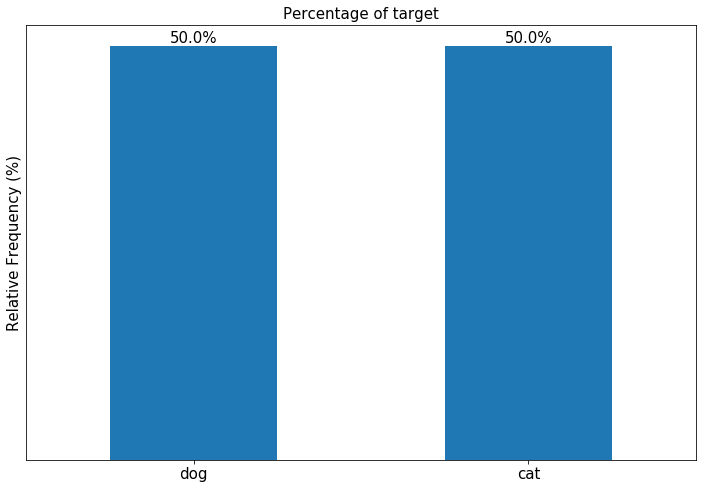

In [46]:
freq_table(data.target)

### Image gallery (new)

Define functions to show numerous pictures together. This is a pretty cool function from another notebook to display numerous amounts of pictures of the same classes. I had one that showed only 6 in my other pneumonia dataset that I tried it out with [here](https://github.com/davidtnly/DeepLearning/blob/master/07-pneumonia-radiograph-imaging/02-model-development.ipynb).

In [47]:
WIDTH=150
HEIGHT=150

In [58]:
def get_side(img, side_type, side_size=5):
    height, width, channel = img.shape
    if side_type=='horizontal':
        return np.ones((height, side_size, channel), dtype=np.float32)*255
    return np.ones((side_size, width, channel), dtype=np.float32)*255

def show_gallery(show='both'):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state=np.random.get_state()
    np.random.shuffle(full_paths)
    np.random.set_state(rng_state)
    np.random.shuffle(targets)
    
    # Loop through images and target
    for path, target in zip(full_paths, targets): # combines both file & target together
        if target != show and show != 'both':
            continue
        counter=counter+1
        if counter%100==0:
            break
        
        # Load image
        img = load_img(path, target_size=(WIDTH, HEIGHT))
        
        # Convert img into array
        img = img_to_array(img)
        hside = get_side(img, side_type='horizontal')
        images.append(img)
        images.append(hside) 
        
        if counter % 10 == 0:
            himage = np.hstack((images))
            vside = get_side(himage, side_type='vertial')
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            # Create images list
            images=list()
            
    gallery = np.vstack((vertical_images))
    plt.figure(figsize=(12, 12))
    plt.xticks([])
    plt.yticks([])
    title = {
        'both': 'Dogs and Cats',
        'cat': 'Cats',
        'dog': 'dogs'
    }
    plt.title('100 Samples of {} of the dataset'.format(title[show]))
    plt.imshow(gallery.astype(np.uint8))          

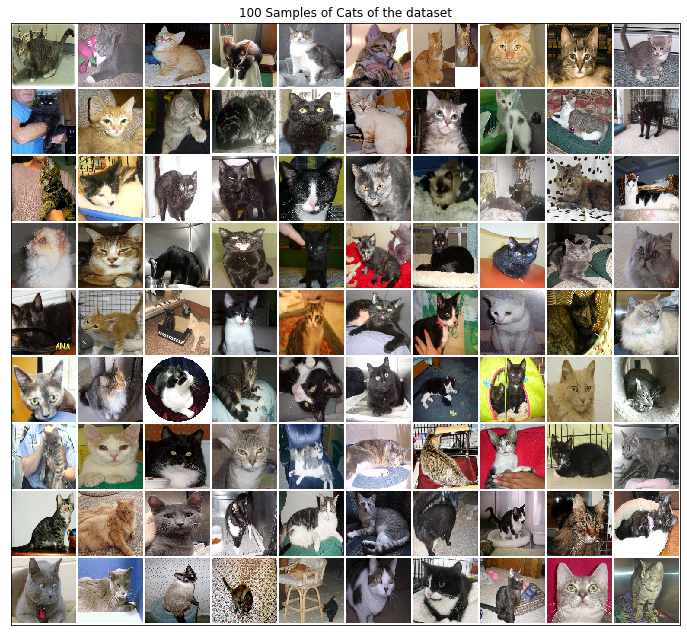

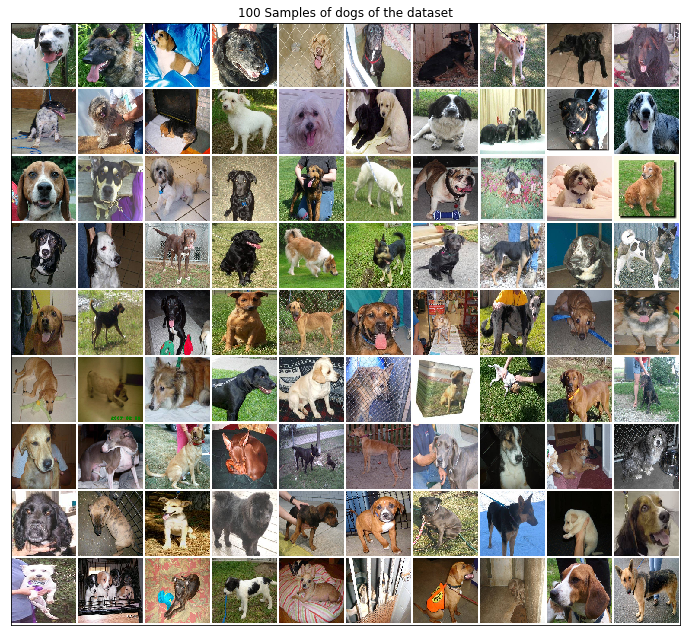

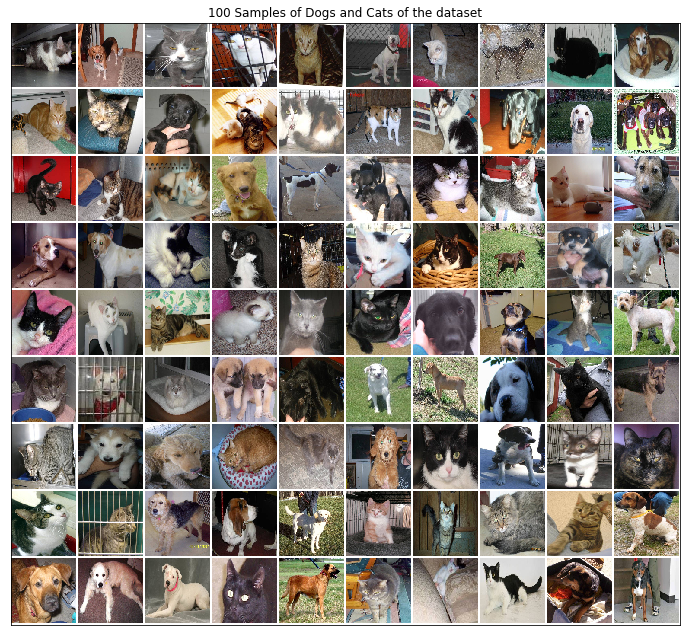

In [60]:
show_gallery(show='cat')
show_gallery(show='dog')
show_gallery()

### CNN

Define a function to show model training and validation scores.

In [97]:
def show_model_history(modelHistory, model_name, w=12, h=6):
    history = pd.DataFrame()
    history['Train Loss'] = modelHistory.history['loss']
    history['Validation Loss'] = modelHistory.history['val_loss']
    history['Train Accuracy'] = modelHistory.history['acc']
    history['Validation Accuracy'] = modelHistory.history['val_acc']
    history.plot(figsize=(w, h))
    plt.title('Model: {} - Train & Validation Loss & Accuracy'.format(model_name))
    plt.show()

### Creating a CNN Architecture from scratch with Keras (1st step)

In [65]:
# Instantiate model
model = models.Sequential()

# First conv block
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second conv block
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Third conv block
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Fourth conv block
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Flatten
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.50))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 146, 146, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

### Compile the model

In [67]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

### Train & test split

In [68]:
data_train, data_test = train_test_split(data, test_size=0.20, random_state=42)

### Define model params

In [89]:
# Define model parameters
EPOCHS = 5
BATCH_SIZE = 150
TARGET_SIZE = 150

### Image augmentation

Using flow_from_dataframe() vs. flow_from_directory()

In [79]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Notebook is using only rescale and not the same as train
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Set generation object path
train_gen = train_datagen.flow_from_dataframe(
    dataframe=data_train,
    x_col='image_path',
    y_col='target',
    target_size=(WIDTH, HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=data_test,
    x_col='image_path',
    y_col='target',
    target_size=(WIDTH, HEIGHT),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [84]:
print('Train shape:', data_train.shape)
print('Test shape:', data_test.shape)

Train shape: (20000, 2)
Test shape: (5000, 2)


In [90]:
val_steps = data_test.shape[0]//BATCH_SIZE
epoch_steps = data_train.shape[0]//BATCH_SIZE

### Fit model

Testing with 5 Epochs.

In [91]:
modelHistory = model.fit_generator(train_gen,
                                   epochs=EPOCHS,
                                   validation_data=test_gen,
                                   validation_steps=val_steps,
                                   steps_per_epoch=epoch_steps
                                  )

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
133/133 [==============================] - 93s 698ms/step - loss: 0.9820 - acc: 0.5539 - val_loss: 1.1612 - val_acc: 0.5149
Epoch 2/5
133/133 [==============================] - 84s 629ms/step - loss: 0.7158 - acc: 0.5907 - val_loss: 0.9599 - val_acc: 0.5649
Epoch 3/5
133/133 [==============================] - 80s 599ms/step - loss: 0.6577 - acc: 0.6224 - val_loss: 0.9126 - val_acc: 0.5849
Epoch 4/5
133/133 [==============================] - 80s 598ms/step - loss: 0.6253 - acc: 0.6515 - val_loss: 0.9969 - val_acc: 0.5901
Epoch 5/5
133/133 [==============================] - 80s 602ms/step - loss: 0.5946 - acc: 0.6810 - val_loss: 1.6182 - val_acc: 0.5707


Train Accuracy: 0.681
Validation Accuracy: 0.571


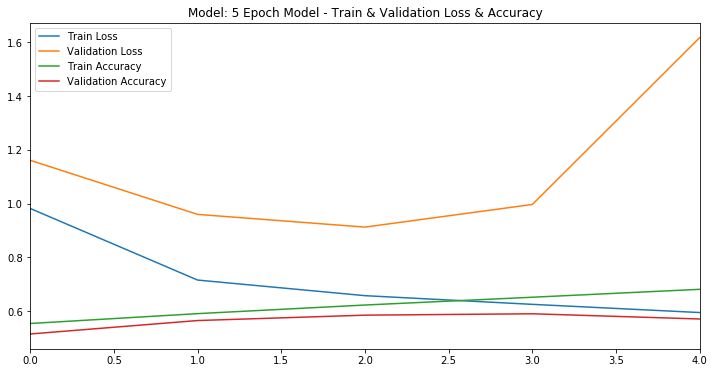

In [101]:
print('Train Accuracy: {:.3f}'.format(modelHistory.history['acc'][-1]))
print('Validation Accuracy: {:.3f}'.format(modelHistory.history['val_acc'][-1]))
show_model_history(modelHistory=modelHistory, model_name='5 Epoch Model', w=12, h=6)

## Transfer Learning: Feature Extractor (Part 2)

---------------

Feature vectors are extracted from the images in the dataset, and these features are classified by supervised machine learning algorithms. Images are given to the CNN model, which makes classification without the feature extraction process.

CNN also allows for the use of pre-trained models on new datasets. This approach is called transfer learning. There are two types of transfer learning.
- Feature Extractor
- Fine Tuning

Transfer learning is based on the paradigm where a model was previously trained on the initial dataset can be used as a starting point on the new dataset. For example, a model that is trained for classification on snake and frog data can be used as a starting point for the classification of other animals. The models of the CNN architectures are trained on the ImageNet dataset and are available in the Keras library. These architectures can be easily used for the purpose of transfer learning on new data like this.

### Load VGG16 model

In [102]:
tl_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))
tl_model.summary()

58892288/58889256 [==============================] - 3s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool

Note: the last layer is (4, 4, 512) so the length of the feature vector will be 8,192.

### Load images

In [109]:
counter=0
features=list()

# Loop through images
for path, target in zip(full_paths, targets):
    img=load_img(path, target_size=(WIDTH, HEIGHT))
    img=img_to_array(img)
    img=np.expand_dims(img, axis=0)
    feature=tl_model.predict(img)
    features.append(feature)
    counter+=1
    if counter%2500==0:
        print('{} images loaded'.format(counter))

2500 images loaded
5000 images loaded
7500 images loaded
10000 images loaded
12500 images loaded
15000 images loaded
17500 images loaded
20000 images loaded
22500 images loaded
25000 images loaded


### Reshape the data in the needed shape for the transfer model

In [110]:
features_arr = np.array(features)
print('Before reshaping, the feature shapes are: ', features_arr.shape)

# Reshape
features_arr = features_arr.reshape(features_arr.shape[0], 8192) # 4*4*512
print('After reshaping, the feature shapes are: ', features_arr.shape)

Before reshaping, the feature shapes are:  (25000, 1, 4, 4, 512)
After reshaping, the feature shapes are:  (25000, 8192)


### Label encoder

In [122]:
le = LabelEncoder()
targets = le.fit_transform(targets)

In [123]:
print('features.shape:', features_arr.shape)
print('targets.shape:', targets.shape)

features.shape: (25000, 8192)
targets.shape: (25000,)


### Train / test split

In [126]:
X_train, X_test, y_train, y_test=train_test_split(features_arr, targets, test_size=0.2, random_state=42)

### Logistic Regression

In [127]:
lr = LogisticRegression(solver='lbfgs')
print('{} training...'.format(lr.__class__.__name__))

# Fit the model
lr.fit(X_train, y_train)

# Predict
y_pred=lr.predict(X_test)

LogisticRegression training...


### Evaluation

In [131]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=['cat', 'dog']))

Accuracy: 0.9474
Confusion Matrix:
 [[2370  142]
 [ 121 2367]]
Classification Report:
               precision    recall  f1-score   support

         cat       0.95      0.94      0.95      2512
         dog       0.94      0.95      0.95      2488

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



### Cross-validation

In [132]:
cv_scores = cross_val_score(LogisticRegression(solver='lbfgs'), features_arr, targets, cv=3)

In [133]:
print('Cross validated scores:{}'.format(cv_scores))
print('Mean of cross validated scores:{:.3f}'.format(cv_scores.mean()))

Cross validated scores:[0.94648428 0.9474442  0.94731157]
Mean of cross validated scores:0.947
